In [1]:
# univariate convlstm example
import pandas as pd
import numpy as np 
import datetime
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Date      datetime64[ns]
Period             int64
Value            float64
dtype: object


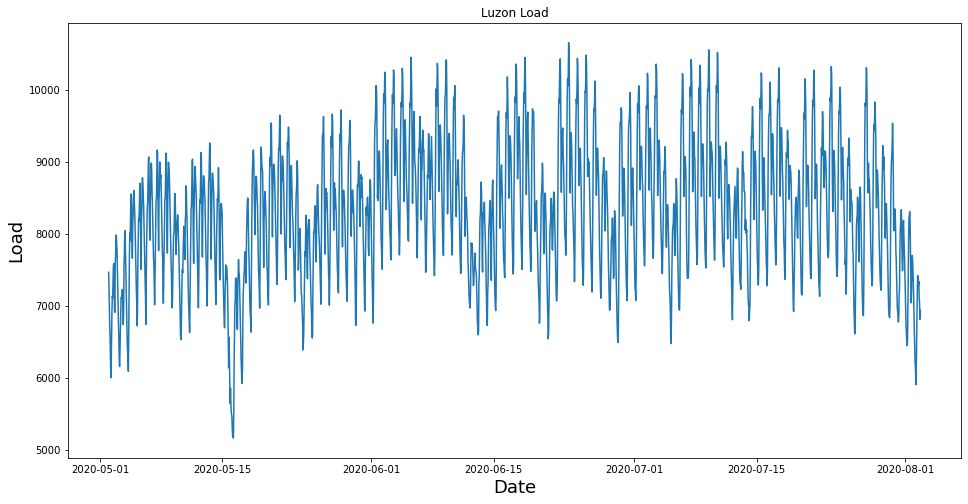

,Date,Period,Value
Date,,,
2020-05-02 00:00:00,2020-05-02 00:00:00,1,7466.0
2020-05-02 01:00:00,2020-05-02 01:00:00,2,7238.1
2020-05-02 02:00:00,2020-05-02 02:00:00,3,6934.5
2020-05-02 03:00:00,2020-05-02 03:00:00,4,6706.9
2020-05-02 04:00:00,2020-05-02 04:00:00,5,6555.9
...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0


In [3]:
# load data + set time
data = pd.read_csv('4-Volume.csv')

# convert the data type of the column to DateTime
data['Date']= pd.to_datetime(data['Date']) 
print(data.dtypes)
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
data.index = data['Date']

plt.figure(figsize=(16, 8))
plt.title('Luzon Load')
plt.plot(data['Value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

data

In [4]:
# extract data for each period + specific date
data_split = data#.loc[data['Period'] == 18]
# define input sequence
data_seq_train = data_split.loc[data_split["Date"] <= "2020-07-27"]
data_seq_test = data_split.loc[data_split["Date"] > "2020-07-27"]
data_seq_test

,Date,Period,Value
Date,,,
2020-07-27 01:00:00,2020-07-27 01:00:00,2,7380.3
2020-07-27 02:00:00,2020-07-27 02:00:00,3,7159.0
2020-07-27 03:00:00,2020-07-27 03:00:00,4,6995.6
2020-07-27 04:00:00,2020-07-27 04:00:00,5,6887.5
2020-07-27 05:00:00,2020-07-27 05:00:00,6,6863.7
...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0


In [5]:
# define input sequence
data_seq_train = list(data_seq_train['Value'])
data_seq_test = list(data_seq_test['Value'])

# data_seq_test

[7380.3,
 7159.0,
 6995.6,
 6887.5,
 6863.7,
 7192.6,
 7978.7,
 8859.7,
 9444.0,
 9811.9,
 9768.2,
 9871.0,
 10302.9,
 10268.7,
 9919.7,
 8993.5,
 8567.7,
 8898.1,
 8977.5,
 8747.1,
 8756.3,
 8588.2,
 8407.8,
 8210.8,
 7870.2,
 7676.9,
 7473.6,
 7393.3,
 7279.6,
 7405.5,
 8250.7,
 8846.5,
 9362.9,
 9518.6,
 9439.5,
 9624.0,
 9826.7,
 9589.9,
 9330.1,
 8595.8,
 8358.8,
 8722.2,
 8884.9,
 8829.5,
 8686.7,
 8522.8,
 8291.7,
 7962.1,
 7748.5,
 7506.6,
 7372.6,
 7278.8,
 7218.4,
 7306.6,
 7923.7,
 8467.0,
 8810.4,
 9224.4,
 9032.8,
 8896.8,
 9068.7,
 8818.5,
 8672.4,
 8114.4,
 7939.9,
 8410.5,
 8398.6,
 8417.6,
 8209.8,
 7970.2,
 7839.9,
 7515.7,
 7271.1,
 7020.5,
 6878.0,
 6853.5,
 6838.6,
 7024.6,
 7552.2,
 8362.3,
 8816.2,
 9017.9,
 9089.6,
 9258.3,
 9533.2,
 9259.9,
 8822.1,
 8050.1,
 8043.9,
 8216.1,
 8344.8,
 8256.2,
 8166.8,
 7766.4,
 7650.2,
 7396.6,
 7181.4,
 6980.1,
 6918.5,
 6835.6,
 6776.7,
 6848.8,
 7160.7,
 7216.9,
 7720.8,
 8054.5,
 8131.4,
 8231.9,
 8334.2,
 8109.2,
 7686.9,

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
# choose a number of time steps
n_steps = 24
# split into samples
X_train, y_train = split_sequence(data_seq_train, n_steps)
X_test, y_test = split_sequence(data_seq_test, n_steps)

X_test

array([[7380.3, 7159. , 6995.6, ..., 8588.2, 8407.8, 8210.8],
       [7159. , 6995.6, 6887.5, ..., 8407.8, 8210.8, 7870.2],
       [6995.6, 6887.5, 6863.7, ..., 8210.8, 7870.2, 7676.9],
       ...,
       [7440.3, 7042.8, 7180.4, ..., 7284.7, 7340.2, 7115.1],
       [7042.8, 7180.4, 7548.5, ..., 7340.2, 7115.1, 7032. ],
       [7180.4, 7548.5, 7699. , ..., 7115.1, 7032. , 6814.4]])

In [7]:
n_features = 1
n_steps = 12
n_seq = 2

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

print(X_train.shape[0], X_train.shape[1])
X_test

2041 2


array([[[[[ 7380.3],
          [ 7159. ],
          [ 6995.6],
          ...,
          [ 9811.9],
          [ 9768.2],
          [ 9871. ]]],


        [[[10302.9],
          [10268.7],
          [ 9919.7],
          ...,
          [ 8588.2],
          [ 8407.8],
          [ 8210.8]]]],



       [[[[ 7159. ],
          [ 6995.6],
          [ 6887.5],
          ...,
          [ 9768.2],
          [ 9871. ],
          [10302.9]]],


        [[[10268.7],
          [ 9919.7],
          [ 8993.5],
          ...,
          [ 8407.8],
          [ 8210.8],
          [ 7870.2]]]],



       [[[[ 6995.6],
          [ 6887.5],
          [ 6863.7],
          ...,
          [ 9871. ],
          [10302.9],
          [10268.7]]],


        [[[ 9919.7],
          [ 8993.5],
          [ 8567.7],
          ...,
          [ 8210.8],
          [ 7870.2],
          [ 7676.9]]]],



       ...,



       [[[[ 7440.3],
          [ 7042.8],
          [ 7180.4],
          ...,
          [ 6798.8],
          

In [8]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,
1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
# fit model
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size = 24)

Epoch 1/200
2041/2041 [==============================] - 3s 1ms/step - loss: 11789449.7322 - mean_absolute_percentage_error: 27.7558
Epoch 2/200
2041/2041 [==============================] - 1s 380us/step - loss: 654371.3375 - mean_absolute_percentage_error: 8.1240
Epoch 3/200
2041/2041 [==============================] - 1s 389us/step - loss: 648326.2734 - mean_absolute_percentage_error: 8.0521
Epoch 4/200
2041/2041 [==============================] - 1s 363us/step - loss: 631671.0243 - mean_absolute_percentage_error: 7.9577
Epoch 5/200
2041/2041 [==============================] - 1s 348us/step - loss: 616002.5220 - mean_absolute_percentage_error: 7.8947
Epoch 6/200
2041/2041 [==============================] - 1s 346us/step - loss: 603166.0475 - mean_absolute_percentage_error: 7.7773
Epoch 7/200
2041/2041 [==============================] - 1s 359us/step - loss: 576874.3103 - mean_absolute_percentage_error: 7.6331
Epoch 8/200
2041/2041 [==============================] - 1s 350us/step - lo

Epoch 123/200
2041/2041 [==============================] - 1s 376us/step - loss: 45274.8648 - mean_absolute_percentage_error: 2.0003
Epoch 124/200
2041/2041 [==============================] - 1s 393us/step - loss: 42975.6404 - mean_absolute_percentage_error: 1.9324
Epoch 125/200
2041/2041 [==============================] - 1s 379us/step - loss: 43051.8291 - mean_absolute_percentage_error: 1.9352
Epoch 126/200
2041/2041 [==============================] - 1s 385us/step - loss: 49481.3481 - mean_absolute_percentage_error: 2.0970
Epoch 127/200
2041/2041 [==============================] - 1s 387us/step - loss: 46377.7796 - mean_absolute_percentage_error: 2.0269
Epoch 128/200
2041/2041 [==============================] - 1s 386us/step - loss: 41580.6014 - mean_absolute_percentage_error: 1.8996
Epoch 129/200
2041/2041 [==============================] - 1s 399us/step - loss: 41417.9549 - mean_absolute_percentage_error: 1.8837
Epoch 130/200
2041/2041 [==============================] - 1s 371us/s

In [9]:
# demonstrate prediction
y_test_hat = model.predict(X_test, verbose=0)
y_test = list(y_test)
for i in range(len(y_test_hat)):
    print(y_test_hat[i],y_test[i])

[7692.134] 7870.2
[7389.4443] 7676.9
[7322.5264] 7473.6
[7211.262] 7393.3
[7282.663] 7279.6
[7338.025] 7405.5
[7857.787] 8250.7
[8865.646] 8846.5
[9221.369] 9362.9
[9356.306] 9518.6
[9352.325] 9439.5
[9602.274] 9624.0
[9772.179] 9826.7
[9564.607] 9589.9
[8977.133] 9330.1
[8821.139] 8595.8
[8332.103] 8358.8
[8319.047] 8722.2
[8717.081] 8884.9
[8903.247] 8829.5
[8632.889] 8686.7
[8337.575] 8522.8
[8278.054] 8291.7
[7914.597] 7962.1
[7573.1025] 7748.5
[7402.895] 7506.6
[7166.464] 7372.6
[7140.742] 7278.8
[7120.5054] 7218.4
[7384.193] 7306.6
[7739.861] 7923.7
[8434.191] 8467.0
[8783.342] 8810.4
[8818.0205] 9224.4
[9135.617] 9032.8
[9127.11] 8896.8
[8860.082] 9068.7
[8851.759] 8818.5
[8403.371] 8672.4
[8358.111] 8114.4
[7923.808] 7939.9
[7907.035] 8410.5
[8546.477] 8398.6
[8455.944] 8417.6
[8257.4795] 8209.8
[7876.362] 7970.2
[7729.6245] 7839.9
[7587.9233] 7515.7
[7103.599] 7271.1
[6953.0664] 7020.5
[6718.845] 6878.0
[6785.8574] 6853.5
[6851.877] 6838.6
[6887.4155] 7024.6
[7417.8228] 7552.2

In [10]:
# calcute MAPE Error on test data

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE=mean_absolute_percentage_error(y_test, y_test_hat)
MAPE

12.60862470890923

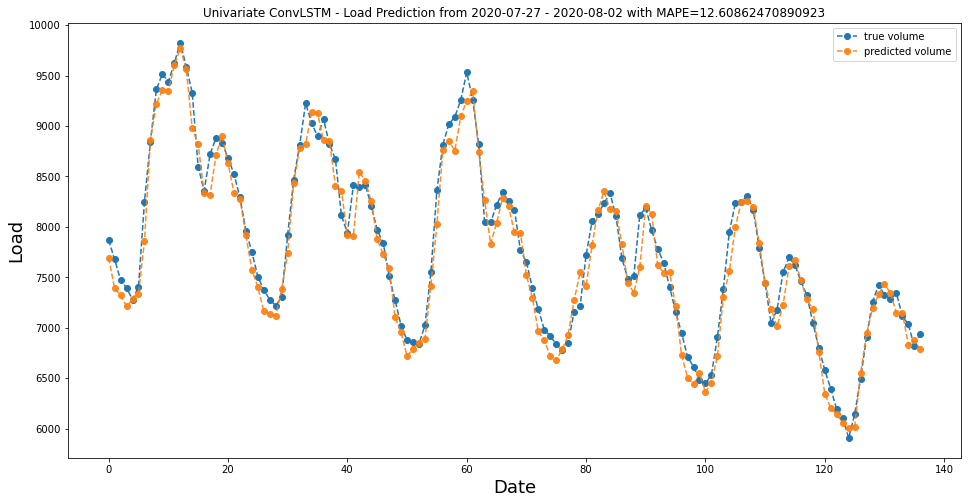

In [11]:
# plot the y_test and y_test_hat (prediction on test data)

plt.figure(figsize=(16, 8))
plt.title('Univariate ConvLSTM - Load Prediction from 2020-07-27 - 2020-08-02 with MAPE='+ str(MAPE))
plt.plot(y_test, 'o--', alpha=1)
plt.plot(y_test_hat, 'o--', alpha=0.9)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.legend(['true volume', 'predicted volume'], loc='upper right')
plt.show()


# Visuliza Model + RMSE + Weights

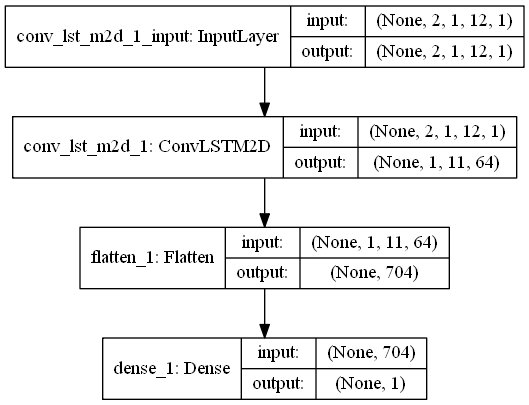

In [12]:
from keras.utils.vis_utils import plot_model
# pip install pydot
# conda install python-graphviz

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

RMSE=measure_rmse(y_test, y_test_hat)
RMSE

172.26687332927554

In [14]:
for layer in model.layers:
    weights = layer.get_weights() 
    
weights


[array([[ 1.44543573e-02],
        [-7.70159215e-02],
        [ 2.46062391e-02],
        [ 1.09707013e-01],
        [-8.92409906e-02],
        [-1.44334882e-03],
        [-7.27050751e-02],
        [ 6.89936280e-02],
        [-8.09054896e-02],
        [-1.10001065e-01],
        [-4.76005450e-02],
        [ 5.62431403e-02],
        [-3.57205719e-02],
        [ 2.97460835e-02],
        [-4.21402790e-02],
        [ 1.02987364e-02],
        [ 6.95201606e-02],
        [ 8.31384510e-02],
        [ 5.56061268e-02],
        [ 6.10992908e-02],
        [-1.20268539e-02],
        [ 6.69646859e-02],
        [ 7.67026246e-02],
        [ 7.72217661e-03],
        [ 1.72445521e-01],
        [-7.12348893e-02],
        [ 6.20142408e-02],
        [-3.67319174e-02],
        [-2.92175915e-02],
        [ 6.37170970e-02],
        [-3.63233872e-02],
        [ 8.29488784e-02],
        [ 7.16672242e-02],
        [ 6.00159764e-02],
        [-2.29490623e-02],
        [-2.34750658e-02],
        [ 4.42064255e-02],
 